# RFM Easy_Money
Francesc
Antonio
Sandra
Cristina
Francisco

## 1. Imports

In [1]:
#Importamos librerías
import sys
import os 

import numpy as np # Arrays
import pandas as pd # Series and Dataframes

import matplotlib.pyplot as plt 
import seaborn as sns # Advanced Plotting 
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
# from google.colab import files #para importar desde google
# from google.colab import drive

pd.options.display.max_rows = 100
plt.style.use('ggplot') # Beautify Plots 

In [2]:
# from colabcode import ColabCode

In [3]:
#A nivel de modelos
from sklearn import model_selection
import xgboost as xgb #este es para hacer decision trees
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import metrics # model evaluation metrics

In [4]:
#Estas funciones son para hacer transformaciones
from scipy import stats
from datetime import datetime

In [5]:
#librería para hacer números random
import random

In [6]:
#json se utiliza para bd de nosql, pero es parecido a los diccionarios de phyton. normalmente tiene esta forma {'ggg`: 'zzzz'}
#Cuando se importa de googlemaps, eso está guardado en un json

import random
import json
from pandas import json_normalize

In [7]:
#para poder ver los datos tenemos que montar el drive
#drive.mount('/content/gdrive')

#MODELIZACIÓN

In [10]:
df_modelo1=pd.read_pickle(r"C:\Users\Usuario\OneDrive\Workplace\Portfolio_Projects\TFM_DSC_Easy_Money\data\df_modelo_pk")

## MLC4.1: Train / Test Split

Identificamos que aproximadamente el 80% cae sobre el 2019-01. Se toma la decisión de hacer en entrenamiento con valores del 2018 y la validación con valores de 2019.

Transformamos las dos últimas variables que nos faltan a números, que son las fechas tanto de entrada como mes de venta. 

In [11]:
df_modelo1['año_entrada'] = df_modelo1['entry_month'].dt.year
df_modelo1['mes_entrada'] = df_modelo1['entry_month'].dt.month

In [12]:
df_modelo1['año_venta'] = df_modelo1['month_sale'].dt.year
df_modelo1['mes_venta'] = df_modelo1['month_sale'].dt.month

In [13]:
df_modelo1['mes_venta']

0         5
1         5
2         5
3         4
4         4
         ..
915788    5
915789    5
915790    5
915791    5
915792    5
Name: mes_venta, Length: 915793, dtype: int64

In [14]:
df_modelo1 = df_modelo1.drop(['entry_month', 'month_sale', 'entry_date'], axis=1)

In [15]:
df_modelo1 = df_modelo1.drop(['pk_sale', 'pk_cid'],axis=1) #Viendo en el primer decision tree, estas variables cuando son seleccionadas no aportan aprendizaje
# Se hace la prueba para corroborar esto.

In [16]:
print(df_modelo1.columns)

Index(['Unnamed: 0', 'age', 'net_margin_log', 'salary_scaled',
       'compro_nuevos_productos', 'product_desc_credit_card',
       'product_desc_debit_card', 'product_desc_em_acount',
       'product_desc_emc_account', 'product_desc_funds',
       ...
       'Provincia_Toledo', 'Provincia_Valencia', 'Provincia_Valladolid',
       'Provincia_Vizcaya', 'Provincia_Zamora', 'Provincia_Zaragoza',
       'año_entrada', 'mes_entrada', 'año_venta', 'mes_venta'],
      dtype='object', length=166)


In [17]:
target_linked_features = ['compro_nuevos_productos'] #Seleccionamos las columnas que hicimos durante el dataunderstanding

In [18]:
df_val = df_modelo1[df_modelo1['año_venta'] == 2019]
df_dev = df_modelo1[df_modelo1['año_venta'] < 2019]

In [19]:
df_dev.shape

(723217, 166)

In [20]:
df_val.shape

(192576, 166)

In [21]:
df_val.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
Index: 192576 entries, 91 to 915792
Columns: 166 entries, Unnamed: 0 to mes_venta
dtypes: float64(2), int64(7), uint8(157)
memory usage: 43.5 MB


In [22]:
df_dev.info(verbose = False)

<class 'pandas.core.frame.DataFrame'>
Index: 723217 entries, 0 to 893498
Columns: 166 entries, Unnamed: 0 to mes_venta
dtypes: float64(2), int64(7), uint8(157)
memory usage: 163.5 MB


In [23]:
df_dev_X = df_dev.drop(df_dev[target_linked_features], axis=1)
df_dev_y = df_dev.loc[:, target_linked_features]

In [24]:
df_val_X = df_val.drop(df_val[target_linked_features], axis=1)
df_val_y = df_val.loc[:, target_linked_features]

In [25]:
df_dev_X.head().T

,0,1,2,3,4
Unnamed: 0,0.000000,1.000000,2.000000,3.000000,4.000000
age,50.000000,50.000000,51.000000,50.000000,50.000000
net_margin_log,6.860559,6.860559,6.860559,4.284965,4.284965
salary_scaled,0.004797,0.004797,0.004797,0.004797,0.004797
product_desc_credit_card,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...
Provincia_Zaragoza,0.000000,0.000000,0.000000,0.000000,0.000000
año_entrada,2018.000000,2018.000000,2018.000000,2018.000000,2018.000000
mes_entrada,4.000000,4.000000,4.000000,4.000000,4.000000
año_venta,2018.000000,2018.000000,2018.000000,2018.000000,2018.000000


In [26]:
df_dev_y.head().T

,0,1,2,3,4
compro_nuevos_productos,0,0,0,0,0


##Random Holdout

In [27]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
                                        df_dev_X, # X 
                                        df_dev_y, # y
                                        test_size = 0.30, # tamaño del split aleatorio 
                                        random_state = 42
)

In [28]:
X_train.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 506251 entries, 428611 to 141179
Columns: 165 entries, Unnamed: 0 to mes_venta
dtypes: float64(2), int64(6), uint8(157)
memory usage: 110.6 MB


In [29]:
X_test.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 216966 entries, 71949 to 125798
Columns: 165 entries, Unnamed: 0 to mes_venta
dtypes: float64(2), int64(6), uint8(157)
memory usage: 47.4 MB


In [30]:
X_train.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,506251.0,453158.214856,269830.496939,0.000000,214473.000000,441319.000000,708310.500000,893497.000000
age,506251.0,34.026736,13.349730,2.000000,23.000000,31.000000,41.000000,102.000000
net_margin_log,506251.0,4.816949,1.439576,3.258097,4.135167,4.255613,4.400603,9.823762
salary_scaled,506251.0,0.002736,0.006663,0.000000,0.000000,0.002202,0.003782,1.000000
product_desc_credit_card,506251.0,0.027352,0.163107,0.000000,0.000000,0.000000,0.000000,1.000000


In [31]:
X_test.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,216966.0,453444.101500,269333.139389,2.000000,215906.250000,443214.000000,707836.750000,893498.000000
age,216966.0,34.018938,13.363259,2.000000,23.000000,31.000000,41.000000,102.000000
net_margin_log,216966.0,4.812399,1.435047,3.258097,4.136765,4.255613,4.399375,9.823762
salary_scaled,216966.0,0.002748,0.006531,0.000000,0.000000,0.002214,0.003788,1.000000
product_desc_credit_card,216966.0,0.026765,0.161395,0.000000,0.000000,0.000000,0.000000,1.000000


In [32]:
y_train.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
compro_nuevos_productos,506251.0,0.031376,0.174331,0.0,0.0,0.0,0.0,1.0


In [33]:
y_test.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
compro_nuevos_productos,216966.0,0.030908,0.173069,0.0,0.0,0.0,0.0,1.0


## Model definition
Para este segundo modelo se hará un GradientBoostinClassifier

Importación de librería

In [34]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

##GradientBoostinClassifier

In [35]:
#GradientBoostingClassifier?

In [36]:
# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(df_dev_X, df_dev_y, test_size=0.3, random_state=42)

# Crear y ajustar el modelo GradientBoostingClassifier
model = GradientBoostingClassifier()
model.fit(X_train, y_train)

# Realizar predicciones en los datos de prueba
y_pred = model.predict(X_test)

# Evaluar el rendimiento del modelo
accuracy = model.score(X_test, y_test)


C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\ensemble\_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


## Model evaluation

In [37]:
# Evaluar el rendimiento del modelo
accuracy = model.score(X_test, y_test)
print(accuracy)

0.9690734953863739


In [38]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_test, y_pred)

In [39]:
recall = recall_score(y_test, y_pred)

In [40]:
f1 = f1_score(y_test, y_pred)

In [41]:
print("Precisión:", precision)
print("Exhaustividad:", recall)
print("Puntuación F1:", f1)

Precisión: 0.0
Exhaustividad: 0.0
Puntuación F1: 0.0


In [42]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[210256,      4],
       [  6706,      0]], dtype=int64)

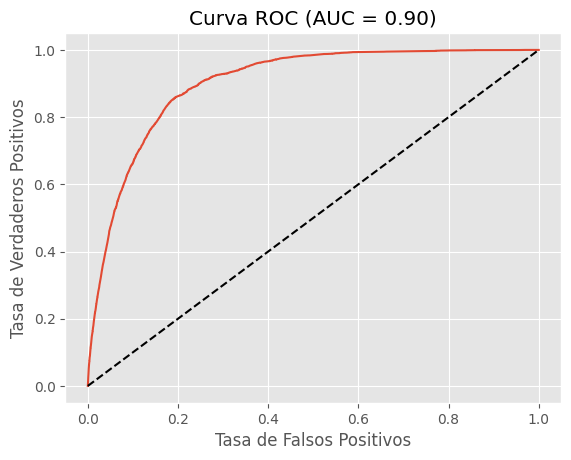

In [43]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Calcular las probabilidades de clase
probas = model.predict_proba(X_test)[:, 1]

# Calcular la curva ROC y el área bajo la curva
fpr, tpr, thresholds = roc_curve(y_test, probas)
auc = roc_auc_score(y_test, probas)

# Graficar la curva ROC
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC (AUC = {:.2f})'.format(auc))
plt.show()

#CONCLUSIÓN

En este segundo modelo realizado con la muestra sin modificar nuestra variable target, que al estar muy desbalanceada, genera también un modelo que con un 96% de probabilidad de éxito en donde dice que nadie compra. 

Se procede a hacer un do un undersampling y oversampling de nuestra variable target: compran productos nuevos. 